<a href="https://colab.research.google.com/github/Siu0901/AI_study/blob/main/%EB%AC%B8%EC%9E%90_%EB%8B%A8%EC%9C%84_RNN_%EA%B3%B5%EB%B6%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 지금까진 전부 입출력 단위가 단어 벡터였다면 예는 문자임
# appl 이 있으면 e 가 들어가야 apple 이 된다 이런식으로 예측하는 거임

In [2]:
# 문자 단위 RNN 언어 (다 대 다)

In [3]:
# 데이터에 대한 이해와 전처리
# import numpy as np
# import urllib.request
# from tensorflow.keras.utils import to_categorical

# urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")

# f = open('11-0.txt', 'rb')
# sentences = []
# for sentence in f:
#   sentence =sentence.strip()
#   sentence = sentence.lower()
#   sentence = sentence.decode('ascii', 'ignore')
#   # \xe2\x80\x99 등과 같은 바이트 열 제거
#   if len(sentence) > 0:
#     sentences.append(sentence)
# f.close()

import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical

# 데이터 로드
urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")

f = open('11-0.txt', 'rb')
sentences = []
for sentence in f: # 데이터로부터 한 줄씩 읽는다.
    sentence = sentence.strip() # strip()을 통해 \r, \n을 제거한다.
    sentence = sentence.lower() # 소문자화.
    sentence = sentence.decode('ascii', 'ignore') # \xe2\x80\x99 등과 같은 바이트 열 제거
    if len(sentence) > 0:
        sentences.append(sentence)
f.close()

In [4]:
sentences[:10]

['*** start of the project gutenberg ebook 11 ***',
 '[illustration]',
 'alices adventures in wonderland',
 'by lewis carroll',
 'the millennium fulcrum edition 3.0',
 'contents',
 'chapter i.     down the rabbit-hole',
 'chapter ii.    the pool of tears',
 'chapter iii.   a caucus-race and a long tale',
 'chapter iv.    the rabbit sends in a little bill']

In [5]:
total_data = ' '.join(sentences[20:])
print('문자 데이터 수:',len(total_data))

문자 데이터 수: 139626


In [6]:
print(total_data[:500])

alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, and what is the use of a book, thought alice without pictures or conversations? so she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting u


In [7]:
char_vocab = sorted(list(set(total_data)))
vocab_size = len(char_vocab)
vocab_size

41

In [8]:
# 문자에 고유한 정수 부여
char_to_index= dict((char, index) for index, char in enumerate(char_vocab))
print(char_to_index)

{' ': 0, '!': 1, '(': 2, ')': 3, '*': 4, ',': 5, '-': 6, '.': 7, '1': 8, ':': 9, ';': 10, '?': 11, '[': 12, ']': 13, '_': 14, 'a': 15, 'b': 16, 'c': 17, 'd': 18, 'e': 19, 'f': 20, 'g': 21, 'h': 22, 'i': 23, 'j': 24, 'k': 25, 'l': 26, 'm': 27, 'n': 28, 'o': 29, 'p': 30, 'q': 31, 'r': 32, 's': 33, 't': 34, 'u': 35, 'v': 36, 'w': 37, 'x': 38, 'y': 39, 'z': 40}


In [9]:
# 정수로부터 문자를 리턴하는 딕셔너리
index_to_char = {}
for key, value in char_to_index.items():
    index_to_char[value] = key

In [10]:
# appl (입력 시퀀스) -> pple (예측해야하는 시퀀스)
train_X = 'appl'
train_y = 'pple'

In [11]:
# 데이터를 만드는 방법은 문장 샘플의 길이를 정하고,
# 해당 길이만큼 문자열 전체를 등분하는 것

In [12]:
seq_length = 60
n_samples = int(np.floor((len(total_data) - 1) / seq_length))
print ('샘플의 수 : {}'.format(n_samples))

샘플의 수 : 2327


In [13]:
train_X = []
train_y = []

for i in range(n_samples):
  # 0:60 -> 60:120 -> 120:180로 loop를 돌면서 문장 샘플을 1개씩 pick.
  X_sample = total_data[i * seq_length: (i+1) * seq_length]

  # 정수 인코딩
  X_encoded = [char_to_index[c] for c in X_sample]
  train_X.append(X_encoded)

  # 오른쪽으로 1칸 쉬프트
  y_sample = total_data[i * seq_length + 1: (i+1) * seq_length + 1]
  y_encoded = [char_to_index[c] for c in y_sample]
  train_y.append(y_encoded)

In [14]:
# train_y[0]은 train_X[0]에서 오른쪽으로 한 칸 쉬프트 된 문장임을 알 수 있다
print('X 데이터의 첫번째 샘플 :',train_X[0])
print('y 데이터의 첫번째 샘플 :',train_y[0])
print('-'*50)
print('X 데이터의 첫번째 샘플 디코딩 :',[index_to_char[i] for i in train_X[0]])
print('y 데이터의 첫번째 샘플 디코딩 :',[index_to_char[i] for i in train_y[0]])

X 데이터의 첫번째 샘플 : [15, 26, 23, 17, 19, 0, 37, 15, 33, 0, 16, 19, 21, 23, 28, 28, 23, 28, 21, 0, 34, 29, 0, 21, 19, 34, 0, 36, 19, 32, 39, 0, 34, 23, 32, 19, 18, 0, 29, 20, 0, 33, 23, 34, 34, 23, 28, 21, 0, 16, 39, 0, 22, 19, 32, 0, 33, 23, 33, 34]
y 데이터의 첫번째 샘플 : [26, 23, 17, 19, 0, 37, 15, 33, 0, 16, 19, 21, 23, 28, 28, 23, 28, 21, 0, 34, 29, 0, 21, 19, 34, 0, 36, 19, 32, 39, 0, 34, 23, 32, 19, 18, 0, 29, 20, 0, 33, 23, 34, 34, 23, 28, 21, 0, 16, 39, 0, 22, 19, 32, 0, 33, 23, 33, 34, 19]
--------------------------------------------------
X 데이터의 첫번째 샘플 디코딩 : ['a', 'l', 'i', 'c', 'e', ' ', 'w', 'a', 's', ' ', 'b', 'e', 'g', 'i', 'n', 'n', 'i', 'n', 'g', ' ', 't', 'o', ' ', 'g', 'e', 't', ' ', 'v', 'e', 'r', 'y', ' ', 't', 'i', 'r', 'e', 'd', ' ', 'o', 'f', ' ', 's', 'i', 't', 't', 'i', 'n', 'g', ' ', 'b', 'y', ' ', 'h', 'e', 'r', ' ', 's', 'i', 's', 't']
y 데이터의 첫번째 샘플 디코딩 : ['l', 'i', 'c', 'e', ' ', 'w', 'a', 's', ' ', 'b', 'e', 'g', 'i', 'n', 'n', 'i', 'n', 'g', ' ', 't', 'o', ' ', 'g', 

In [15]:
print(train_X[1])
print(train_y[1])

[19, 32, 0, 29, 28, 0, 34, 22, 19, 0, 16, 15, 28, 25, 5, 0, 15, 28, 18, 0, 29, 20, 0, 22, 15, 36, 23, 28, 21, 0, 28, 29, 34, 22, 23, 28, 21, 0, 34, 29, 0, 18, 29, 9, 0, 29, 28, 17, 19, 0, 29, 32, 0, 34, 37, 23, 17, 19, 0, 33]
[32, 0, 29, 28, 0, 34, 22, 19, 0, 16, 15, 28, 25, 5, 0, 15, 28, 18, 0, 29, 20, 0, 22, 15, 36, 23, 28, 21, 0, 28, 29, 34, 22, 23, 28, 21, 0, 34, 29, 0, 18, 29, 9, 0, 29, 28, 17, 19, 0, 29, 32, 0, 34, 37, 23, 17, 19, 0, 33, 22]


In [16]:
# 문자 단위 RNN에서는 입력 시퀀스에 대해서 워드 임베딩을 하지 않음
# 임베딩층을 사용하지 않기에 train_X에 대해 워드 임베딩 함

In [17]:
train_X = to_categorical(train_X)
train_y = to_categorical(train_y)

print('train_X의 크기(shape) : {}'.format(train_X.shape)) # 원-핫 인코딩
print('train_y의 크기(shape) : {}'.format(train_y.shape)) # 원-핫 인코딩

train_X의 크기(shape) : (2327, 60, 41)
train_y의 크기(shape) : (2327, 60, 41)


In [18]:
train_X[0][0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.])

In [19]:
# 샘플 수 2327개, 입력 시퀀스의 길이 60, 각 벡터의 차원이 41임을 의미함

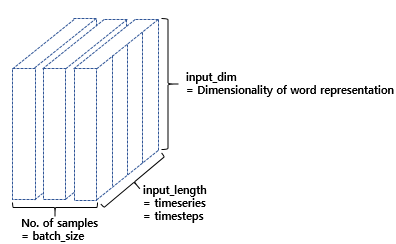

In [20]:
# 모델 설계하기

# 모델은 다 대 다 구조의 LSTM을 사용하며 LSTM 은닉층은 두 개를 사용한다.
# 전결합층을 출력층으로 문자 집합 크기만큼의 뉴런을 배치하여 모델을 설계한다.

# 해당 모델은 모든 시점에서 모든 가능한 문자 중 하나의 문자를 예측하는
# 다중 클래스 분류 문제를 수행하는 모델

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

hidden_units = 256

model = Sequential()
model.add(LSTM(hidden_units, input_shape=(None, train_X.shape[2]),return_sequences=True))
model.add(LSTM(hidden_units, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=80, verbose=2)

Epoch 1/80
73/73 - 40s - 543ms/step - accuracy: 0.1846 - loss: 3.0282
Epoch 2/80
73/73 - 31s - 427ms/step - accuracy: 0.2505 - loss: 2.6921
Epoch 3/80
73/73 - 32s - 442ms/step - accuracy: 0.3386 - loss: 2.3430
Epoch 4/80
73/73 - 40s - 546ms/step - accuracy: 0.3770 - loss: 2.1810
Epoch 5/80
73/73 - 41s - 563ms/step - accuracy: 0.4063 - loss: 2.0681
Epoch 6/80
73/73 - 32s - 444ms/step - accuracy: 0.4299 - loss: 1.9730
Epoch 7/80
73/73 - 40s - 546ms/step - accuracy: 0.4493 - loss: 1.8957
Epoch 8/80
73/73 - 42s - 574ms/step - accuracy: 0.4680 - loss: 1.8301
Epoch 9/80
73/73 - 34s - 463ms/step - accuracy: 0.4845 - loss: 1.7716
Epoch 10/80
73/73 - 39s - 534ms/step - accuracy: 0.4983 - loss: 1.7188
Epoch 11/80
73/73 - 33s - 445ms/step - accuracy: 0.5097 - loss: 1.6724
Epoch 12/80
73/73 - 31s - 428ms/step - accuracy: 0.5213 - loss: 1.6264
Epoch 13/80
73/73 - 32s - 443ms/step - accuracy: 0.5307 - loss: 1.5850
Epoch 14/80
73/73 - 33s - 448ms/step - accuracy: 0.5411 - loss: 1.5463
Epoch 15/80
73/

In [26]:
def sentence_generation(model, length):
  # 문자에 대한 랜덤한 정수 생성
  ix = [np.random.randint(vocab_size)]

  # 랜덤한 정수로부터 맵핑되는 문자 생성
  y_char = [index_to_char[ix[-1]]]
  print(ix[-1], '번 문자', y_char[-1], '로 예측을 시작!')

  # (1, length, 41) 크기의 x 생성. #LSTM의 입력 시퀀스 생성
  X = np.zeros((1, length, vocab_size))

  for i in range(length):
    # X[0][i][예측한 문자의 인덱스] = 1, 즉, 예측 문자를 다음 입력 시퀀스에 추가
    X[0][i][ix[-1]] = 1
    print(index_to_char[ix[-1]], end="")
    ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
    y_char.append(index_to_char[ix[-1]])
  return (' ').join(y_char)

In [30]:
result = sentence_generation(model, 100)
print(result)

18 번 문자 d 로 예측을 시작!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47

In [28]:
# ㅅㅂ 진짜 문장이 걍 존나 그럴 듯한 문장을 생성함